In [49]:
import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt

In [50]:
X = datasets.fetch_covtype().data[:3000]
y = datasets.fetch_covtype().target[:3000]
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_va, y_train, y_va = train_test_split(X_1, y_1)

print(X_train.shape, y_train.shape)
print(np.unique(y_train))  # 7分类任务

(2025, 54) (2025,)
[1 2 3 4 5 6 7]


In [51]:
enc = OrdinalEncoder()
y_train_enc = enc.fit_transform(y_train.reshape(-1, 1))
y_test_enc = enc.transform(y_test.reshape(-1, 1))
y_va_enc = enc.fit_transform(y_va.reshape(-1, 1))
print(np.unique(y_train_enc))
print(y_train_enc.shape)

[0. 1. 2. 3. 4. 5. 6.]
(2025, 1)


In [52]:
# label.shape = (num_sample, )
train_dataset = lgb.Dataset(data=X_train, label=y_train_enc.reshape(-1, ))
val_dataset = lgb.Dataset(data=X_va, label=y_va_enc.reshape(-1, ))

In [53]:
from sklearn.metrics import log_loss


def my_gbm_loss(y_pred, y_true):
    """lightgbm自定义验证数据集损失函数格式"""
    # 多分类任务中,y_pred先按类进行分组(比如前7个值是y_true[0]的预测值,最后7个值是y_true[-1]的预测值)
    reshape_y_pred = np.transpose(y_pred.reshape(7, -1))  # 这是一个7分类任务
    loss = log_loss(y_true.get_label(), reshape_y_pred)
    print("y_true.shape:{0},y_pred.shape:{1},reshape_y_pred.shape:{2}".format(y_true.get_label().shape, y_pred.shape,
                                                                              reshape_y_pred.shape))
    # 返回值格式:评估函数的名称(不含空格), 评估结果, 评估结果是否越高越高(比如AUC是越高越好,损失值是越低越好)
    return 'MY_GBM_LOSS', loss, False

In [54]:
params = {"objective": "multiclass",
          "num_class": 7,
          "verbose": -4, "metric": ("multi_logloss",)}

eval_set = [train_dataset, val_dataset]
evals_result = {}  # 储存评估指标(内置和自定义)结果

model = lgb.train(params=params,
                  train_set=train_dataset,
                  early_stopping_rounds=20,
                  # List of data to be evaluated on during training.
                  valid_sets=eval_set,
                  # This dictionary used to store all evaluation results of all the items in valid_sets.
                  evals_result=evals_result,
                  feval=my_gbm_loss)  # Customized evaluation function

# 预测结果为概率向量(多分类)
# X_test: numpy array, pandas DataFrame
model.predict(X_test)

y_true.shape:(2025,),y_pred.shape:(14175,),reshape_y_pred.shape:(2025, 7)
y_true.shape:(675,),y_pred.shape:(4725,),reshape_y_pred.shape:(675, 7)
[1]	training's multi_logloss: 1.33937	training's MY_GBM_LOSS: 1.33937	valid_1's multi_logloss: 1.39757	valid_1's MY_GBM_LOSS: 1.39757
Training until validation scores don't improve for 20 rounds
y_true.shape:(2025,),y_pred.shape:(14175,),reshape_y_pred.shape:(2025, 7)
y_true.shape:(675,),y_pred.shape:(4725,),reshape_y_pred.shape:(675, 7)
[2]	training's multi_logloss: 1.14909	training's MY_GBM_LOSS: 1.14909	valid_1's multi_logloss: 1.22439	valid_1's MY_GBM_LOSS: 1.22439
y_true.shape:(2025,),y_pred.shape:(14175,),reshape_y_pred.shape:(2025, 7)
y_true.shape:(675,),y_pred.shape:(4725,),reshape_y_pred.shape:(675, 7)
[3]	training's multi_logloss: 1.00913	training's MY_GBM_LOSS: 1.00913	valid_1's multi_logloss: 1.09716	valid_1's MY_GBM_LOSS: 1.09716
y_true.shape:(2025,),y_pred.shape:(14175,),reshape_y_pred.shape:(2025, 7)
y_true.shape:(675,),y_pred.s

array([[3.21944506e-02, 9.64268644e-01, 3.94498557e-04, ...,
        1.09907547e-03, 4.61693106e-04, 1.37476427e-03],
       [1.52722637e-04, 2.02588364e-03, 7.73187774e-05, ...,
        9.97570584e-01, 8.97887107e-05, 4.34491496e-05],
       [2.86146849e-04, 2.09443099e-04, 2.15884367e-04, ...,
        1.39725394e-04, 3.98063370e-04, 2.71127438e-05],
       ...,
       [1.91151422e-01, 7.97690772e-01, 1.23645477e-03, ...,
        3.43919395e-03, 1.44897780e-03, 4.38533859e-03],
       [6.68118598e-03, 1.41362710e-02, 7.80033865e-01, ...,
        9.88401626e-03, 1.80873766e-01, 1.89659282e-03],
       [2.02850711e-01, 7.83955504e-01, 1.48881532e-03, ...,
        8.34142928e-03, 1.73853325e-03, 8.43946707e-04]])

In [55]:
evals_result

{'training': OrderedDict([('multi_logloss',
               [1.3393658862743618,
                1.1490874826315902,
                1.0091329342632949,
                0.8957796415104613,
                0.8017285166262922,
                0.7211135613392494,
                0.651140933381923,
                0.5911296170585736,
                0.5397079053389915,
                0.49397101782751146,
                0.4554475863711241,
                0.42139225915232403,
                0.38920493965596265,
                0.3609109512054404,
                0.33471189424963255,
                0.31228941190845955,
                0.291524813118963,
                0.2722115462218662,
                0.2542812745270117,
                0.23934653920913554,
                0.224573468414026,
                0.2114625137114044,
                0.1993509939687763,
                0.18740815279379686,
                0.1769179392046847,
                0.16752523809683487,
               

In [56]:
evals_result['training'].keys()

odict_keys(['multi_logloss', 'MY_GBM_LOSS'])

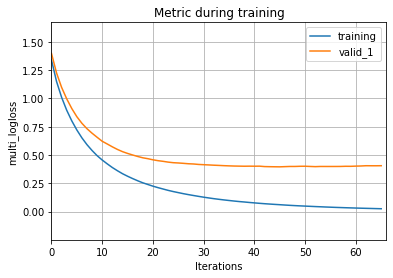

In [57]:
# Plot one metric during training.
ax = lgb.plot_metric(evals_result, metric='multi_logloss')  # multi_logloss指标绘制
plt.show()

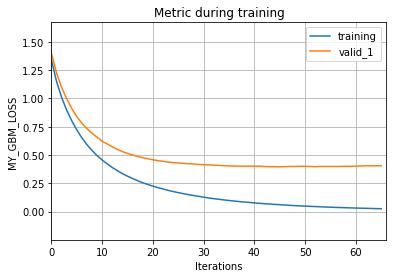

In [58]:
ax1 = lgb.plot_metric(evals_result, metric="MY_GBM_LOSS")  # MY_GBM_LOSS指标绘制
plt.show()

In [59]:
# 特征的相对重要性
model.feature_importance()

array([1539,  671,  354,  821,  587, 1479,  613,  541,  750, 1296,  127,
          0,   27,  102,   37,   17,    0,    0,    0,    0,    0,    0,
          0,   61,    0,   99,   36,    0,    0,    0,   21,    4,    0,
        133,    0,    4,   27,    6,    0,    0,    0,    0,   58,  127,
          0,    8,   31,    0,    0,    0,    0,   17,    2,    0])

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

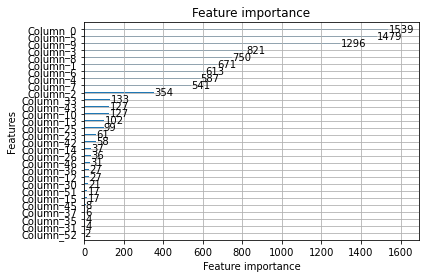

In [60]:
lgb.plot_importance(model)

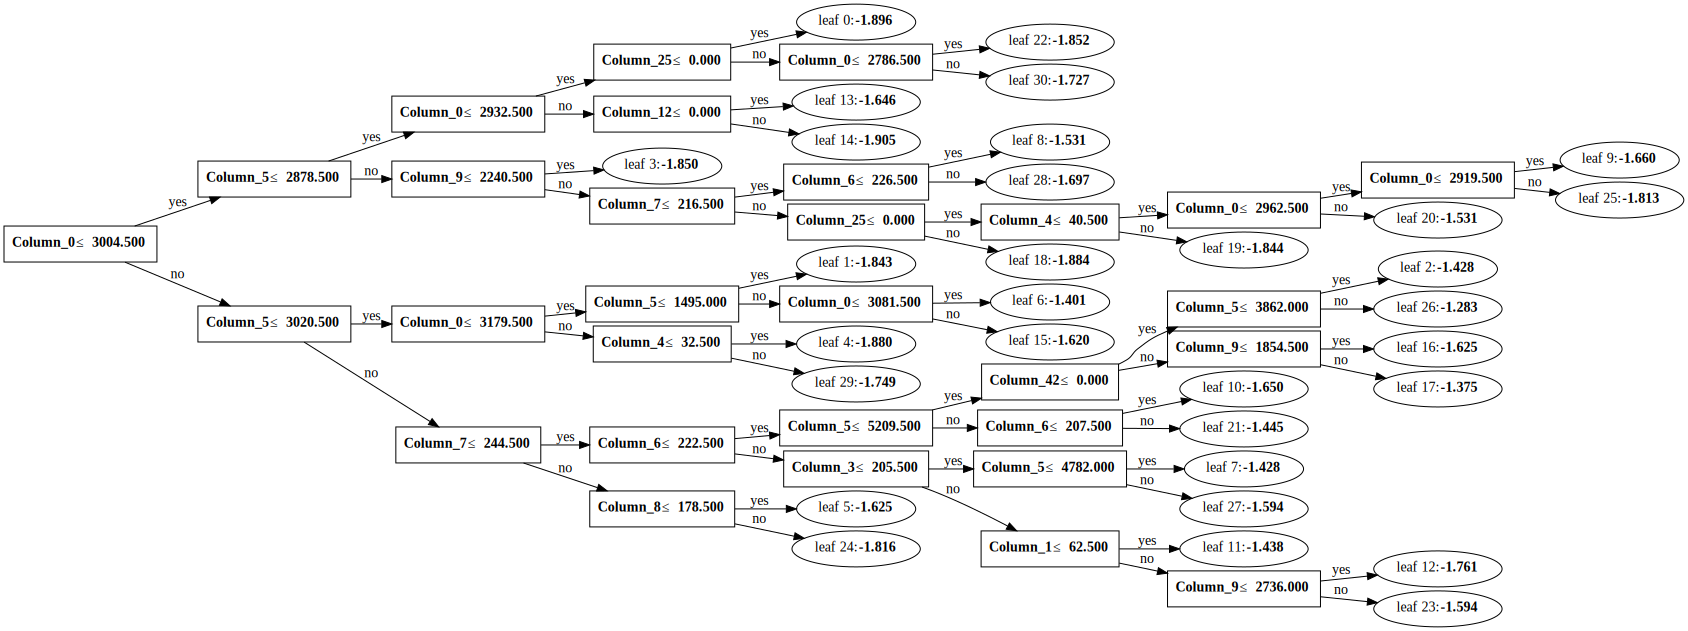

In [61]:
# 可视化lgb分割过程
img = lgb.create_tree_digraph(model)
img

In [62]:
# 数据类型为graphviz.dot.Digraph
type(img)




graphviz.dot.Digraph